## Minimal notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

import seaborn as sns

from collections import Counter
import itertools

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/manuelmorales/miniconda3/envs/training/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import database

In [13]:
# always use False
LOCAL = False

if LOCAL:
    f = open('data/inspire_LA.json','r')
    df = json.load(f)
    f.close()
else:
    r = requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df = r.json()

db_master = pd.DataFrame(df)
db_master.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors,gender
0,H.Albrecht.1,Venezuela,"[{'value': 'hartwig.albrecht@desy.de', 'curren...","Albrecht, Hermann","[{'value': 'H.Albrecht.1', 'schema': 'INSPIRE ...","Unlisted, VE",912061,"{'value': 'Albrecht, Hartwig', 'preferred_name...","[{'recid': 2023395, 'year': '2021', 'citation_...",[{'record': {'$ref': 'https://inspirehep.net/a...,1018731,[],male
1,D.M.B.R.1,Venezuela,None,"Bellorin, David","[{'value': 'D.M.B.R.1', 'schema': 'INSPIRE BAI'}]","Unlisted, VE",912061,"{'value': 'R., David M. Bellorin'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023397,[],male
2,D.F.Mundarain.1,Chile,None,"Mundarain, Douglas F.","[{'value': 'D.F.Mundarain.1', 'schema': 'INSPI...",Catolica del Norte U.,908143,"{'value': 'Mundarain, Douglas F.'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023398,[],male
3,R.Gaitan.2,Venezuela,"[{'value': 'rgaitan@uc.edu.ve', 'current': Fal...","Dominguez, Yessica","[{'value': 'R.Gaitan.2', 'schema': 'INSPIRE BA...","Unlisted, VE",912061,"{'value': 'Gaitan, Rolando', 'preferred_name':...","[{'recid': 1863076, 'year': '2021', 'citation_...","[{'rank': 'PHD', 'record': {'$ref': 'https://i...",1864347,[],male
4,J.Ntahompagaze.1,Rwanda,None,"Ntahompagaze, Joseph","[{'value': 'J.Ntahompagaze.1', 'schema': 'INSP...","EAIFR, Kigali",1636656,"{'value': 'Ntahompagaze, Joseph'}","[{'recid': 2087212, 'year': '2022', 'citation_...",None,2087213,[],male


# All countries in the database

In [15]:
# find all countries in json
all_countries = db_master['country'].unique()
# get rid of Nonetypes in the database
all_countries = [country for country in all_countries if country is not None]
# sort countries 
all_countries.sort()

print(len(all_countries))

for country in all_countries:
    print(country)
    
# format country 
def format_country(country):
    country = country.lower()
    ans = country.replace(" ", "_")
    return ans

115
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei Darussalam
Bulgaria
Canada
Chile
China
Colombia
Congo
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Holy See (Vatican City State)
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Republic of
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Korea, Republic of
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lithuania
Luxembourg
Madagascar
Malaysia
Malta
Mexico
Moldova
Mongolia
Montenegro
Morocco
Netherlands
New Zealand
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine, State of
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russian Federation
Rwanda
Saudi Arabia
Serbia and Montenegro
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan

# Latin American countries 

In [16]:
# 19 Latin American countries indexed in the database
LA_countries = [
    'Argentina',
    'Bolivia',
    'Brazil',
    'Chile',
    'Colombia',
    'Costa Rica',
    'Cuba',
    'Dominican Republic', # new
    'Ecuador',
    'El Salvador', # new
    'Guatemala',
    'Honduras',
    'Mexico',
    'Panama', # new
    'Paraguay',
    'Peru',
    'Puerto Rico', # new
    'Uruguay',
    'Venezuela'
]

# Jamaica, Bahamas not included. 

LA_countries_format = [format_country(country) for country in LA_countries]
print(LA_countries_format)

['argentina', 'bolivia', 'brazil', 'chile', 'colombia', 'costa_rica', 'cuba', 'dominican_republic', 'ecuador', 'el_salvador', 'guatemala', 'honduras', 'mexico', 'panama', 'paraguay', 'peru', 'puerto_rico', 'uruguay', 'venezuela']


In [17]:
# import from INSPIREHEP_new_articles_per_year.ipynb

def generate_dataframe(country: str) -> pd.DataFrame:
    """
    Generate a DataFrame whose rows are all the publications of a given country.
    The `recid` entry is unique for each publication.
    """
    # select column
    db = db_master[db_master['country']==country].reset_index(drop=True)
    
    # obtain list of the institutions of the country
    inst_list = db['institution_id'].drop_duplicates().to_list()
    
    # stack papers and select the ones from the appropriate institutions
    dp = pd.DataFrame(db.papers.apply(pd.Series).stack().to_list()).reset_index(drop=True)
    dp = dp[dp['institution_id'].isin(inst_list)]
    
    # get rid of paper duplicates
    dp = dp.drop_duplicates(subset='recid')
    
    # skip entries without listed `year`. This ignores the papers that do not have year.
    # For this reason, the sum over all years will not equal the total number of publications
    # from the other notebook. In fact, the result here will be less or equal to it. 
    dp = dp[pd.to_numeric(dp['year'], errors='coerce').notnull()].reset_index(drop=True)
    
    # transform to numerical values
    dp['year'] = pd.to_numeric(dp['year'])
    # get rid of old entries
    dp = dp[dp['year'] >= 1900]
    
    return dp

In [18]:
def generate_dataframe_latam():
    """
    """
    
    df_latam = {}
    for country in LA_countries:
        df_latam[country] = generate_dataframe(country)

    df_latam_stack = pd.concat([df_latam[country] for country in LA_countries], ignore_index=True)
    df_latam = df_latam_stack.drop_duplicates(subset='recid')

    return df_latam

In [19]:
my_df = generate_dataframe_latam()
my_df

,recid,year,citation_count,primary_arxiv_category,journal_id,author_id,institution_id,rank,start_date,end_date,current,institution,country
0,884148,2011,1,[hep-th],None,F.A.Schaposnik.1,902950,SENIOR,1986,None,True,La Plata U.,Argentina
1,2030209,2022,1,[hep-th],None,F.A.Schaposnik.1,902950,SENIOR,1986,None,True,La Plata U.,Argentina
2,2098035,2022,0,[],1613973,F.A.Schaposnik.1,902950,SENIOR,1986,None,True,La Plata U.,Argentina
3,1372753,2015,8,[hep-th],None,F.A.Schaposnik.1,902950,SENIOR,1986,None,True,La Plata U.,Argentina
4,693926,2005,24,[hep-th],None,F.A.Schaposnik.1,902950,SENIOR,1986,None,True,La Plata U.,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48408,249252,1987,17,[],None,A.Patino.1,905162,NaN,NaN,NaN,NaN,NaN,NaN
48409,376997,1994,0,[gr-qc],1214738,H.Rago.1,905162,NaN,NaN,NaN,NaN,NaN,NaN
48410,320615,1991,0,[],None,H.Rago.1,905162,NaN,NaN,NaN,NaN,NaN,NaN
48411,471432,1999,28,[gr-qc],1214779,H.Hernandez.2,905162,SENIOR,1999,None,True,"Andes U., Merida",Venezuela


In [20]:
# Group by the 'year' column and sum the 'citation_count' for each group
df_citation_per_year = my_df.groupby('year')['citation_count'].sum().reset_index()

# Rename the columns for clarity
df_citation_per_year.columns = ['year', 'total_citation_count']

# Display the new DataFrame
df_citation_per_year


,year,total_citation_count
0,1946,1
1,1950,16
2,1953,256
3,1954,111
4,1958,7
...,...,...
63,2018,24457
64,2019,20551
65,2020,14498
66,2021,9520


In [34]:
# Group by the 'year' column and sum the 'citation_count' for each group
df_citation_per_year = my_df.groupby('year')['citation_count'].sum().reset_index()

# Rename the columns for clarity
df_citation_per_year.columns = ['year', 'total_citation_count']

# Create a range of all years from the minimum to the maximum year in the original DataFrame
all_years = pd.DataFrame({'year': range(my_df['year'].min(), my_df['year'].max() + 1)})

# Merge the new DataFrame with the all_years DataFrame, filling missing years with zero citations
df_citation_per_year = pd.merge(all_years, df_citation_per_year, on='year', how='left')

# Fill NaN values in the 'total_citation_count' column with 0
df_citation_per_year['total_citation_count'].fillna(0, inplace=True)

# Convert the citation count to integers if needed
df_citation_per_year['total_citation_count'] = df_citation_per_year['total_citation_count'].astype(int)

# Only up to 2021
df_citation_per_year = df_citation_per_year[df_citation_per_year['year'] <= 2021]

# Display the new DataFrame
df_citation_per_year


,year,total_citation_count
0,1946,1
1,1947,0
2,1948,0
3,1949,0
4,1950,16
...,...,...
71,2017,23091
72,2018,24457
73,2019,20551
74,2020,14498


# The world numbers

In [35]:
def load_world_citations():
    """
    Load the DataFrame of all the papers in the world and gives the citations column.

    Returns:
        pd.DataFrame: The DataFrame of all the papers of the world. The index is the year and the column is the number of papers.
    """

    df_world = pd.read_csv('world_papers.csv')
    df_world = df_world[['year', 'Citations']]
    df_world.rename(columns={'Citations': 'total_citations'}, inplace=True)
    df_world = df_world[:-2]
    df_world['year'] = pd.to_numeric(df_world['year'])

    return df_world

In [36]:
df_world = load_world_citations()

In [37]:
df_world

,year,total_citations
0,1946,6118
1,1947,9619
2,1948,16166
3,1949,20202
4,1950,15331
...,...,...
71,2017,776436
72,2018,515254
73,2019,683985
74,2020,410667


In [48]:
def generate_citations_percentage(df_latam, df_world):
    """
    Generate a DataFrame with the percentage of citations of Latin America with respect to the world.

    Parameters:
        df_latam (pd.Series): The number of citations of papers published a given year in Latin America.
        df_world (pd.Series): The number of citations of papers published a given year in the world.

    Returns:
        pd.DataFrame: The percentage of citations of Latin America with respect to the world.
    """

    # Combine the two DataFrames
    df_latam = df_latam.rename(columns={'total_citation_count': 'LA'})
    df_latam['World'] = df_world['total_citations']
    df_latam['Percentage'] = df_latam['LA'] / df_latam['World'] * 100

    return df_latam

In [49]:
df_combined = generate_citations_percentage(df_citation_per_year, df_world)
df_combined

,year,LA,World,Percentage
0,1946,1,6118,0.016345
1,1947,0,9619,0.000000
2,1948,0,16166,0.000000
3,1949,0,20202,0.000000
4,1950,16,15331,0.104364
...,...,...,...,...
71,2017,23091,776436,2.973973
72,2018,24457,515254,4.746591
73,2019,20551,683985,3.004598
74,2020,14498,410667,3.530354


# Generate histogram

In [52]:
import matplotlib.pyplot as plt

def plot_citations_percentage(df_combined, save=False):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(17,4))

    # Plot the data on the axis
    ax.bar(df_combined["year"], df_combined['Percentage'])

    # Set the labels and title
    ax.set_xlabel('Year', size=14, labelpad=8)
    ax.set_ylabel('Percentage', labelpad=8, size=14)
    ax.set_title(f"Latin American citations compared to global citations", size=15, pad=12)

    # Set the tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase label size for major ticks

    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.3)

    # Display the plot
    plt.show()

    # Optional: Save the plot as a PDF
    if save:
        namefig = "citations_world_comparison"
        fig.savefig(f'/Users/manuelmorales/inspireauth/figures/world_comparison/{namefig}.pdf', dpi=150, bbox_inches='tight')

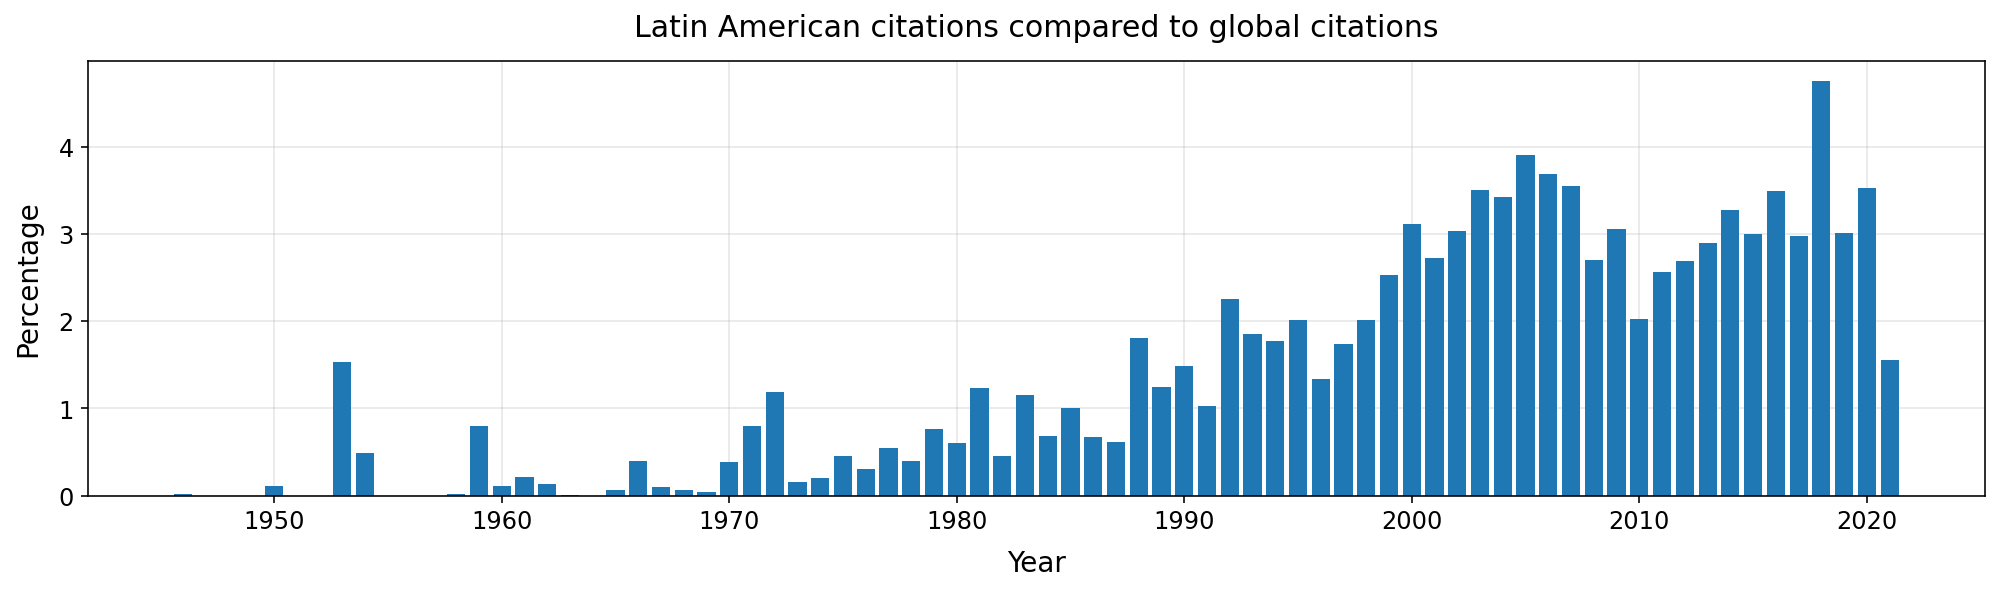

In [53]:
plot_citations_percentage(df_combined)